# Navier Stokes Equatoin

In [1]:
import numpy as np
import time
import scipy.sparse.linalg as sp_la
import matplotlib.pyplot as plt

# --- Core imports ---
from pycutfem.core.mesh import Mesh
from pycutfem.core.dofhandler import DofHandler
from pycutfem.utils.meshgen import structured_quad

# --- UFL-like imports ---
from pycutfem.ufl.functionspace import FunctionSpace
from pycutfem.ufl.expressions import (
    TrialFunction, TestFunction, VectorTrialFunction, VectorTestFunction,
    Function, VectorFunction, Constant, grad, inner, dot, div
)
from pycutfem.ufl.measures import dx
from pycutfem.ufl.forms import BoundaryCondition, assemble_form
from pycutfem.fem.mixedelement import MixedElement

# ============================================================================
#    NEW: Verification Data and Plotting Function
# ============================================================================

# Digitized data from Ghia, Ghia, and Shin (1982), Table 1 for Re=100
ghia_data_re100 = {
    'y_locations': np.array([0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]),
    'u_velocity_on_vertical_centerline': np.array([0.0, -0.0722, -0.1364, -0.2282, -0.2928, -0.3239, -0.3273, -0.3017, -0.2452, -0.1553, -0.0524, 0.0033, 1.0]),
    'x_locations': np.array([0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]),
    'v_velocity_on_horizontal_centerline': np.array([0.0, 0.0886, 0.1608, 0.2804, 0.3556, 0.3789, 0.3547, 0.2971, 0.2223, 0.1463, 0.0712, 0.0396, 0.0])
}

def create_verification_plot(dof_handler, u_solution, reference_data):
    """
    Extracts velocity profiles from the solution and plots them against
    Ghia et al. reference data for verification.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle("Verification Against Ghia, Ghia & Shin (1982) for Re=100", fontsize=16)

    # --- 1. u-velocity on vertical centerline (x=0.5) ---
    ux_dof_coords = dof_handler.get_dof_coords('ux')
    centerline_mask = np.isclose(ux_dof_coords[:, 0], 0.5)
    y_coords = ux_dof_coords[centerline_mask, 1]

    # Get all 'ux' values and filter them
    ux_values = u_solution[0].nodal_values
    u_centerline = ux_values[centerline_mask]

    # Sort for plotting
    sort_indices = np.argsort(y_coords)
    y_coords_sorted = y_coords[sort_indices]
    u_centerline_sorted = u_centerline[sort_indices]

    ax = axes[0]
    ax.plot(u_centerline_sorted, y_coords_sorted, 'b-', label='FEM Solution', lw=2)
    ax.plot(reference_data['u_velocity_on_vertical_centerline'], reference_data['y_locations'], 'ro', label='Ghia et al. (1982)', mfc='none')
    ax.set_title('u-velocity along Vertical Centerline (x=0.5)')
    ax.set_xlabel('u-velocity')
    ax.set_ylabel('Y-coordinate')
    ax.grid(True, linestyle=':')
    ax.legend()

    # --- 2. v-velocity on horizontal centerline (y=0.5) ---
    uy_dof_coords = dof_handler.get_dof_coords('uy')
    centerline_mask = np.isclose(uy_dof_coords[:, 1], 0.5)
    x_coords = uy_dof_coords[centerline_mask, 0]

    # Get all 'uy' values and filter them
    uy_values = u_solution[1].nodal_values
    v_centerline = uy_values[centerline_mask]

    # Sort for plotting
    sort_indices = np.argsort(x_coords)
    x_coords_sorted = x_coords[sort_indices]
    v_centerline_sorted = v_centerline[sort_indices]

    ax = axes[1]
    ax.plot(x_coords_sorted, v_centerline_sorted, 'b-', label='FEM Solution', lw=2)
    ax.plot(reference_data['x_locations'], reference_data['v_velocity_on_horizontal_centerline'], 'ro', label='Ghia et al. (1982)', mfc='none')
    ax.set_title('v-velocity along Horizontal Centerline (y=0.5)')
    ax.set_xlabel('X-coordinate')
    ax.set_ylabel('v-velocity')
    ax.grid(True, linestyle=':')
    ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()








In [2]:
# 1. ============================================================================
#    SETUP (Meshes, DofHandler, BCs)
# ===============================================================================
L, H = 1.0, 1.0
# MODIFIED: Increased resolution for better accuracy
NX, NY = 32, 32
nodes_q2, elems_q2, _, corners_q2 = structured_quad(L, H, nx=NX, ny=NY, poly_order=2)
mesh_q2 = Mesh(nodes=nodes_q2, element_connectivity=elems_q2, elements_corner_nodes=corners_q2, element_type="quad", poly_order=2)
mixed_element = MixedElement(mesh_q2, field_specs={'ux': 2, 'uy': 2, 'p': 1})

dof_handler = DofHandler(mixed_element, method='cg')

# Tag boundaries for applying BCs
bc_tags = {
    'bottom_wall': lambda x,y: np.isclose(y,0),
    'left_wall':   lambda x,y: np.isclose(x,0),
    'right_wall':  lambda x,y: np.isclose(x,L),
    'top_lid':     lambda x,y: np.isclose(y,H)
}
mesh_q2.tag_boundary_edges(bc_tags)

# Tag a single node for pressure pinning
dof_handler.tag_dof_by_locator(
    tag='pressure_pin_point', field='p',
    locator=lambda x, y: np.isclose(x, 0.0) and np.isclose(y, 0.0),
    find_first=True
)

# MODIFIED: Boundary conditions for the classic lid-driven cavity problem
bcs = [
    # No-slip on bottom, left, and right walls
    BoundaryCondition('ux', 'dirichlet', 'bottom_wall', lambda x,y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'bottom_wall', lambda x,y: 0.0),
    BoundaryCondition('ux', 'dirichlet', 'left_wall',   lambda x,y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'left_wall',   lambda x,y: 0.0),
    BoundaryCondition('ux', 'dirichlet', 'right_wall',  lambda x,y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'right_wall',  lambda x,y: 0.0),
    # Moving lid on the top wall (ux=1, uy=0)
    BoundaryCondition('ux', 'dirichlet', 'top_lid',     lambda x,y: 1.0),
    BoundaryCondition('uy', 'dirichlet', 'top_lid',     lambda x,y: 0.0),
    # Pin pressure at one point to ensure a unique solution
    BoundaryCondition('p', 'dirichlet', 'pressure_pin_point',lambda x,y: 0.0)
]

bcs_homog = [BoundaryCondition(bc.field, bc.method, bc.domain_tag, lambda x,y: 0.0) for bc in bcs]
print(f"DofHandler info: {dof_handler.info()}")

=== DofHandler (CG) ===
        ux: 4225 DOFs @ offset 0
        uy: 4225 DOFs @ offset 9
         p: 1089 DOFs @ offset 18
  total : 9539
DofHandler info: None


In [3]:
# 2. ============================================================================
#    UFL FORMULATION
# ===============================================================================
rho = Constant(1.0)
dt = Constant(0.1)
theta = Constant(1.0) # Use Backward Euler for stability (theta=1.0)
# MODIFIED: Set viscosity for Re=100
mu = Constant(0.01) # Re = (1.0 * 1.0 * 1.0) / 0.01 = 100

velocity_space = FunctionSpace("velocity", ['ux', 'uy'])
pressure_space = FunctionSpace("pressure", ['p'])

du = VectorTrialFunction(velocity_space, dof_handler=dof_handler)
dp = TrialFunction(pressure_space, dof_handler=dof_handler)
v = VectorTestFunction(velocity_space, dof_handler=dof_handler)
q = TestFunction(pressure_space, dof_handler=dof_handler)

u_k = VectorFunction(name="u_k", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_k = Function(name="p_k", field_name='p', dof_handler=dof_handler)
u_n = VectorFunction(name="u_n", field_names=['ux', 'uy'], dof_handler=dof_handler)
# p_n is not needed for the steady state formulation if theta=1.0, but we keep it for consistency
p_n = Function(name="p_n", field_name='p', dof_handler=dof_handler)

# 3. ============================================================================
#    SOLVER LOOP (Modified for Steady-State Convergence)
# ===============================================================================
# --- Simulation Parameters ---
# MODIFIED: We run until steady state, not for a fixed time T_end
steady_state_tol = 1e-5
max_timesteps = 200
newton_tol = 1e-6
max_newton_iter = 15


--- Solving Time Step 1 | t = 0.10s ---
  Newton iteration 1 | Residual Norm: 1.130e-01
  Newton iteration 2 | Residual Norm: 2.836e-03
  Newton iteration 3 | Residual Norm: 1.653e-05
  Newton iteration 4 | Residual Norm: 2.620e-10
    Newton converged in 4 iterations.
  Change in solution (L2 norm): 5.696e+00

--- Solving Time Step 2 | t = 0.20s ---
  Newton iteration 1 | Residual Norm: 1.591e-02
  Newton iteration 2 | Residual Norm: 3.168e-04
  Newton iteration 3 | Residual Norm: 2.737e-07
    Newton converged in 3 iterations.
  Change in solution (L2 norm): 2.424e+00

--- Solving Time Step 3 | t = 0.30s ---
  Newton iteration 1 | Residual Norm: 6.531e-03
  Newton iteration 2 | Residual Norm: 1.136e-04
  Newton iteration 3 | Residual Norm: 3.427e-08
    Newton converged in 3 iterations.
  Change in solution (L2 norm): 1.533e+00

--- Solving Time Step 4 | t = 0.40s ---
  Newton iteration 1 | Residual Norm: 4.138e-03
  Newton iteration 2 | Residual Norm: 5.959e-05
  Newton iteration 3

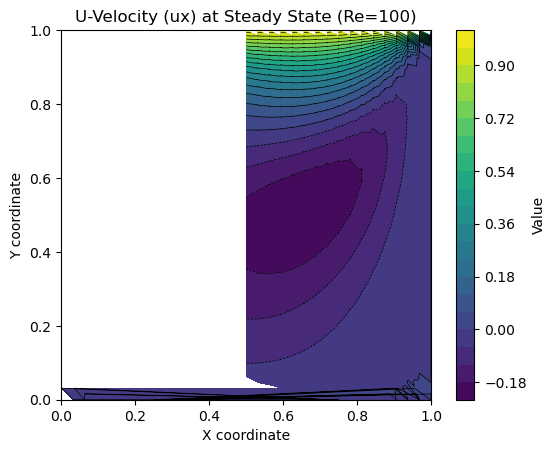

Plotting component: 'uy'


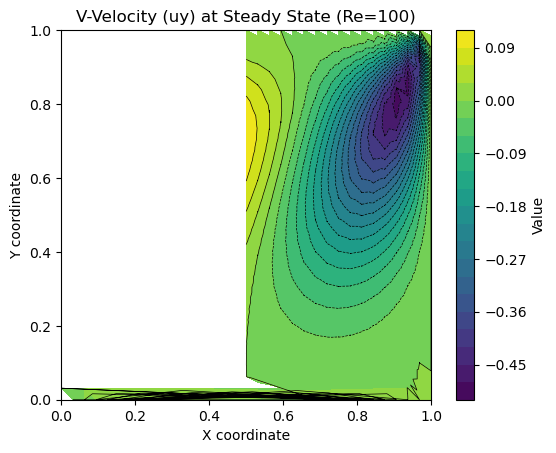

ValueError: triangles are indices into the points and must be in the range 0 <= i < 1089 but found value 4224

In [4]:
# --- Initialize Solution Functions ---
u_k.nodal_values.fill(0.0)
p_k.nodal_values.fill(0.0)
u_n.nodal_values.fill(0.0)
p_n.nodal_values.fill(0.0)

# Apply initial boundary conditions to u_n (the t=0 state)
dof_handler.apply_bcs(bcs, u_n, p_n)

# --- Main Time-Stepping Loop (to reach steady state) ---
for n in range(max_timesteps):
    t = (n + 1) * dt.value
    print(f"\n--- Solving Time Step {n+1} | t = {t:.2f}s ---")

    # Initial guess for Newton is the solution from the previous step
    u_k.nodal_values[:] = u_n.nodal_values[:]
    p_k.nodal_values[:] = p_n.nodal_values[:]
    
    # Apply non-homogeneous BCs to the current iteration guess
    dof_handler.apply_bcs(bcs, u_k, p_k)

    # --- Inner Newton Iteration Loop ---
    for k in range(max_newton_iter):
        # Jacobian and Residual definitions (using theta-method)
        jacobian = (
            rho * dot(du, v) / dt
            + theta * rho * dot(dot(grad(u_k), du), v)
            + theta * rho * dot(dot(grad(du), u_k), v)
            + theta * mu * inner(grad(du), grad(v))
            - dp * div(v)
            + q * div(du)
        ) * dx()

        residual = (
            rho * dot(u_k - u_n, v) / dt
            + theta * dot(rho * dot(grad(u_k), u_k), v)
            + (1.0 - theta) * dot(rho * dot(grad(u_n), u_n), v)
            + theta * mu * inner(grad(u_k), grad(v))
            + (1.0 - theta) * mu * inner(grad(u_n), grad(v))
            - p_k * div(v)
            + q * div(u_k)
        ) * dx()

        # We solve J*delta_U = -R
        A, R_vec = assemble_form(jacobian == -residual, dof_handler=dof_handler, bcs=bcs_homog, quad_order=6)
        
        norm_res = np.linalg.norm(R_vec)
        print(f"  Newton iteration {k+1} | Residual Norm: {norm_res:.3e}")

        if norm_res < newton_tol:
            print(f"    Newton converged in {k+1} iterations.")
            break
        
        delta_U = sp_la.spsolve(A, R_vec)
        
        dof_handler.add_to_functions(delta_U, [u_k, p_k])
        dof_handler.apply_bcs(bcs, u_k, p_k)
    else:
        raise RuntimeError(f"Newton's method did not converge after {max_newton_iter} iterations.")

    # --- Check for steady-state convergence ---
    solution_change = np.linalg.norm(u_k.nodal_values - u_n.nodal_values)
    print(f"  Change in solution (L2 norm): {solution_change:.3e}")
    if solution_change < steady_state_tol and n > 0:
        print(f"\n--- Steady state reached at t={t:.2f}s ---")
        u_n.nodal_values[:] = u_k.nodal_values[:]
        p_n.nodal_values[:] = p_k.nodal_values[:]
        break

    # Update solution for the next time step
    u_n.nodal_values[:] = u_k.nodal_values[:]
    p_n.nodal_values[:] = p_k.nodal_values[:]
else:
    print(f"\n--- Max timesteps ({max_timesteps}) reached. Solution may not be fully steady. ---")


# 4. ============================================================================
#    POST-PROCESSING AND VERIFICATION
# ===============================================================================
print("\nSimulation finished. Generating plots...")

# --- Plot Final Solution Contours ---
# The plot method from your VectorFunction class is used here.
u_n.plot(field='ux', title='U-Velocity (ux) at Steady State (Re=100)', levels=20, cmap='viridis')
u_n.plot(field='uy', title='V-Velocity (uy) at Steady State (Re=100)', levels=20, cmap='viridis')
p_n.plot(title='Pressure (p) at Steady State (Re=100)', levels=20, cmap='viridis')

# --- Generate Quantitative Verification Plot ---
create_verification_plot(dof_handler, u_n, ghia_data_re100)

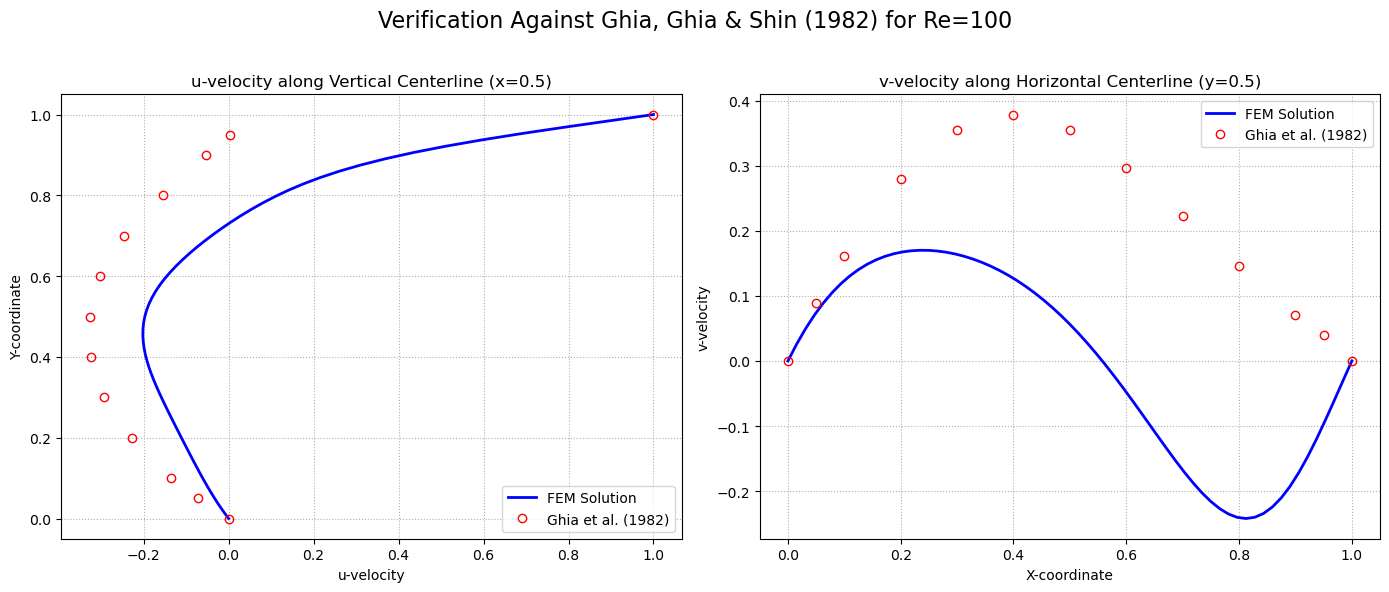

In [5]:
create_verification_plot(dof_handler, u_n, ghia_data_re100)

In [17]:
# --------------------------------------------------------------------
#  Robust triangulation for *any* field in a MixedElement space
# --------------------------------------------------------------------
from __future__ import annotations
import numpy as np
import matplotlib.tri as mtri
from typing import List

def triangulate_field(mesh, dof_handler, field: str, *, strict: bool = False) -> mtri.Triangulation:
    """
    Build a Matplotlib Triangulation that matches the DOFs of ``field``.

    * Works for triangles **and** quads, any polynomial order.
    * Safe for mixed-order spaces (e.g. Q2-Q1): elements whose corner node
      is **not** a DOF of the field are skipped or (if *strict*) raise.

    Parameters
    ----------
    mesh        : pycutfem.core.mesh.Mesh
    dof_handler : pycutfem.core.dofhandler.DofHandler
    field       : str        – field name (e.g. 'ux', 'p')
    strict      : bool       – raise instead of skipping incomplete elements
    """
    # 1.  Global DOFs and their coordinates in *field order*
    gdofs   = dof_handler.get_field_slice(field)                     # list[int]  :contentReference[oaicite:0]{index=0}
    node_ids: List[int] = [dof_handler._dof_to_node_map[d][1] for d in gdofs]  # mapping stored during build :contentReference[oaicite:1]{index=1}
    coords  = mesh.nodes_x_y_pos[node_ids]                           # shape (n,2)
    x, y    = coords[:, 0], coords[:, 1]

    # helper: map physical node-id → local index (0…n-1)
    id2local = {nid: i for i, nid in enumerate(node_ids)}

    # 2.  Element-wise connectivity (remapped to local indices)
    tris = []
    if mesh.element_type == "tri":
        for tri in mesh.corner_connectivity:
            try:
                tris.append([id2local[tri[0]], id2local[tri[1]], id2local[tri[2]]])
            except KeyError:
                if strict: raise ValueError("Field missing a triangle corner node.")
                continue
    elif mesh.element_type == "quad":
        for quad in mesh.corner_connectivity:
            try:
                # split into two triangles (0-1-3, 1-2-3)
                tris.append([id2local[quad[0]], id2local[quad[1]], id2local[quad[3]]])
                tris.append([id2local[quad[1]], id2local[quad[2]], id2local[quad[3]]])
            except KeyError:
                if strict: raise ValueError("Field missing a quadrilateral corner node.")
                continue
    else:
        raise KeyError(f"Unsupported element_type '{mesh.element_type}'")

    # 3.  Fallback: if *many* elements were skipped, rely on Delaunay
    if len(tris) < max(1, len(coords) // 5):        # heuristic – tweak if desired
        return mtri.Triangulation(x, y)

    return mtri.Triangulation(x, y, np.asarray(tris, dtype=int))

def plot(self, field: str = None, kind: str = 'contour', **kwargs):
    """
    Visualizes the vector function.

    Requires matplotlib to be installed.

    Args:
        field (str, optional): The name of a specific component to plot
            (e.g., 'ux'). If None, the behavior is determined by 'kind'.
            Defaults to None.
        kind (str, optional): The type of plot. Can be 'contour' to show
            scalar components or 'quiver' to show vector arrows.
            This is ignored if 'field' is specified. Defaults to 'contour'.
        **kwargs: Additional keyword arguments passed to the underlying
                    matplotlib plot function (e.g., title='My Plot').
    """
    if field is not None:
        found = False
        for comp in self.components:
            if comp.field_name == field:
                print(f"Plotting component: '{field}'")
                comp.plot(**kwargs)
                found = True
                break
        if not found:
            raise ValueError(f"Field '{field}' not found in VectorFunction components: {self.field_names}")
        return

    if kind == 'contour':
        print(f"Plotting all components of '{self.name}' as separate contour plots...")
        for i, comp in enumerate(self.components):
            # Pass a default title for each component if none is provided
            comp_title = kwargs.get('title', f'Component: {comp.name}')
            # Create a copy of kwargs to avoid modifying it in the loop
            comp_kwargs = kwargs.copy()
            comp_kwargs['title'] = comp_title
            comp.plot(**comp_kwargs)
    elif kind == 'quiver':
        self._plot_quiver(**kwargs)
    else:
        raise ValueError(f"Unsupported plot kind '{kind}'. Choose 'contour' or 'quiver'.")

def _plot_quiver(self, *,          # <-- keep the same public signature
                stride: int = 1,   # decimate arrows to avoid clutter
                background: bool | str = "magnitude",
                **kwargs):
    """
    Quiver plot that **always** matches the field’s DOF layout.

    Parameters
    ----------
    stride : int, optional
        Use every *stride*-th DOF for the arrows. 1 → all nodes (default 1).
    background : bool | str, optional
        ``False`` – no colour wash behind arrows.
        ``True``  – filled contour of |u|.
        ``"ux"``/``"uy"``/``"p"`` … any scalar component name → plot that
        component instead of the magnitude.  (Default ``"magnitude"`` which is
        equivalent to ``True``.)
    **kwargs :
        Passed straight to ``ax.quiver`` (e.g. `color='k'`, `scale=50` …).
    """
    if self._dof_handler is None:
        raise RuntimeError("VectorFunction needs an attached DofHandler.")
    if len(self.field_names) != 2:
        raise NotImplementedError("Quiver is implemented only for 2-D vectors.")

    fld_u, fld_v = self.field_names
    dh   = self._dof_handler
    mesh = dh.fe_map[fld_u]

    # --- coordinates + values (1-to-1 with DOFs) ---------------------
    coords = dh.get_dof_coords(fld_u)                                
    x, y   = coords[:, 0], coords[:, 1]
    u_vals = self.components[0].nodal_values
    v_vals = self.components[1].nodal_values
    if len(u_vals) != len(x):
        raise ValueError("Mismatch between nodal values and coordinate length.")

    # optional arrow decimation
    sl = slice(None, None, stride)
    x_q, y_q, u_q, v_q = x[sl], y[sl], u_vals[sl], v_vals[sl]

    # --- background colour-wash --------------------------------------
    tri_obj = triangulate_field(mesh, dh, fld_u)
    fig, ax = plt.subplots(figsize=(8, 8))

    if background:
        if background is True or background == "magnitude":
            scalar, label = np.hypot(u_vals, v_vals), "|u|"
        else:  # any scalar component name
            comp = next((c for c in self.components if c.field_name == background), None)
            if comp is None:
                raise ValueError(f"background='{background}' not a component.")
            scalar, label = comp.nodal_values, background
        levels = kwargs.pop("levels", 15)
        cmap   = kwargs.pop("cmap",   "viridis")
        tcf = ax.tricontourf(tri_obj, scalar, levels=levels, cmap=cmap)
        fig.colorbar(tcf, ax=ax, label=label)

    # --- arrows -------------------------------------------------------
    q_defaults = dict(angles="xy", scale_units="xy", scale=None, color="k")
    title = kwargs.pop('title', f"Vector field: {self.name}")
    q_defaults.update(kwargs)
    ax.quiver(x_q, y_q, u_q, v_q, **q_defaults)

    ax.set_title(title)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    dx = np.ptp(x)    # instead of x.ptp()
    dy = np.ptp(y)    # instead of y.ptp()
    ax.set_xlim(x.min() - 0.05 * dx, x.max() + 0.05 * dx)
    ax.set_ylim(y.min() - 0.05 * dy, y.max() + 0.05 * dy)
    plt.show()

def plot2(self, **kwargs):
        """ Function.plot(**kwargs) -> None
        Creates a 2D filled contour plot of the scalar function.
        """
        if self._dof_handler is None:
            raise RuntimeError("Cannot plot a function without an associated DofHandler.")
        mesh = self._dof_handler.fe_map.get(self.field_name)
        if mesh is None:
            raise RuntimeError(f"Field '{self.field_name}' not found in DofHandler's fe_map.")
        
       
        z = self.nodal_values

            
        triangulation = triangulate_field(mesh, self._dof_handler, self.field_name)
        fig, ax = plt.subplots()
        title = kwargs.pop('title', f'Scalar Field: {self.name}')
        plot_kwargs = {'cmap': 'viridis', 'levels': 15}
        plot_kwargs.update(kwargs)
        
        contour = ax.tricontourf(triangulation, z, **plot_kwargs)
        fig.colorbar(contour, ax=ax, label='Value')
        ax.set_title(title)
        ax.set_xlabel('X coordinate'); ax.set_ylabel('Y coordinate')
        ax.set_aspect('equal', adjustable='box')
        ax.tricontour(triangulation, z, colors='k', linewidths=0.5, levels=plot_kwargs['levels'])
        plt.show()

# monkey-patch the plot method into VectorFunction
VectorFunction.plot = plot
VectorFunction._plot_quiver = _plot_quiver
import types
u_n.plot = types.MethodType(plot, u_n)
u_n._plot_quiver = types.MethodType(_plot_quiver, u_n)
u_n[0].plot = types.MethodType(plot2, u_n[0])
u_n[1].plot = types.MethodType(plot2, u_n[1])
p_n.plot = types.MethodType(plot2, p_n)


Plotting component: 'ux'


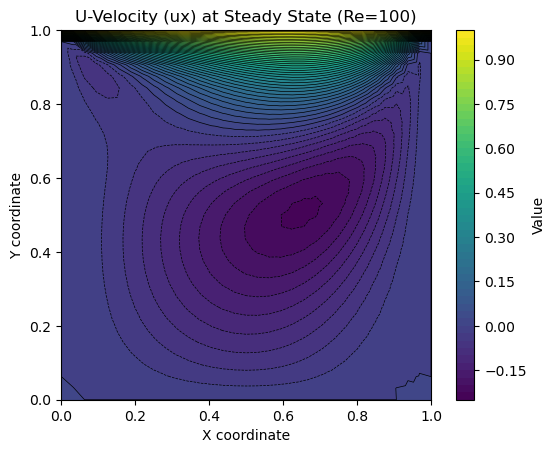

Plotting component: 'uy'


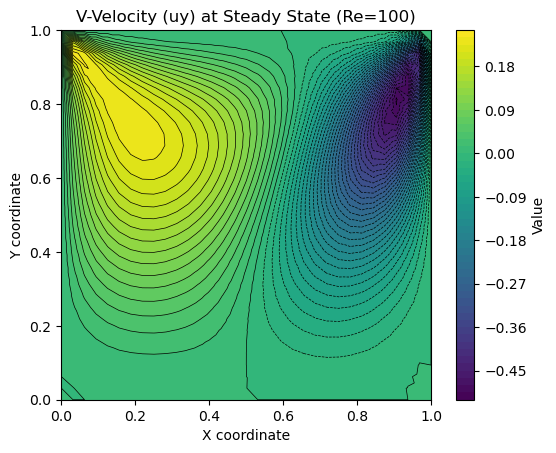

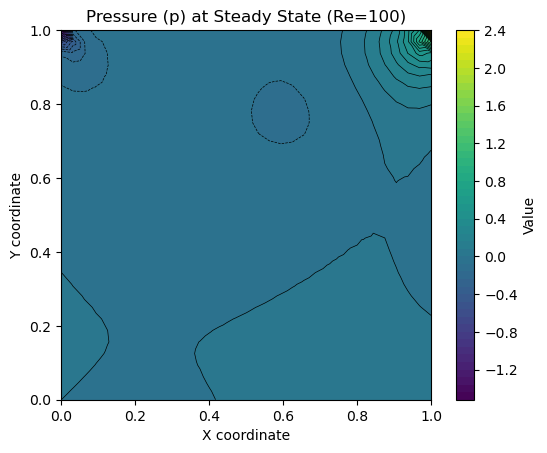

In [19]:
u_n.plot(field='ux', title='U-Velocity (ux) at Steady State (Re=100)', levels=50, cmap='viridis')
u_n.plot(field='uy', title='V-Velocity (uy) at Steady State (Re=100)', levels=50, cmap='viridis')
p_n.plot(title='Pressure (p) at Steady State (Re=100)', levels=50, cmap='viridis')

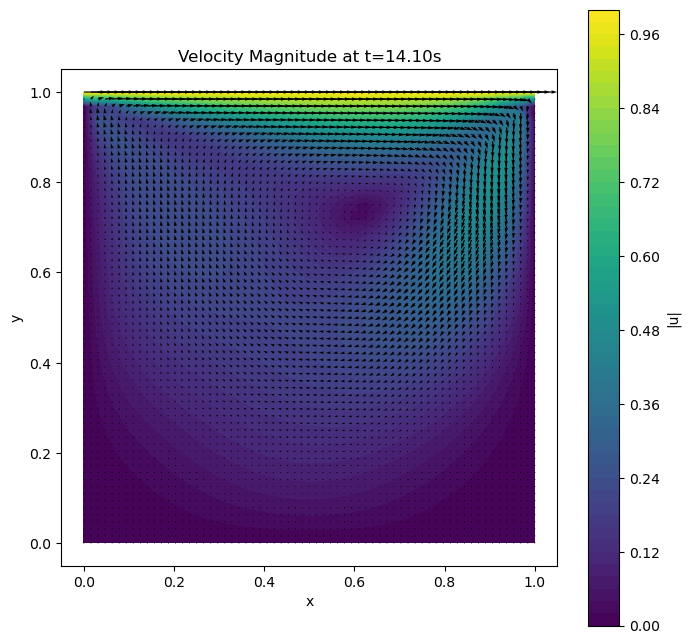

In [20]:
# u_n.plot(kind='contour', title='U-Velocity (ux) at Steady State (Re=100)', levels=20)
u_n.plot(kind='quiver', title=f"Velocity Magnitude at t={t:.2f}s", levels = 50)

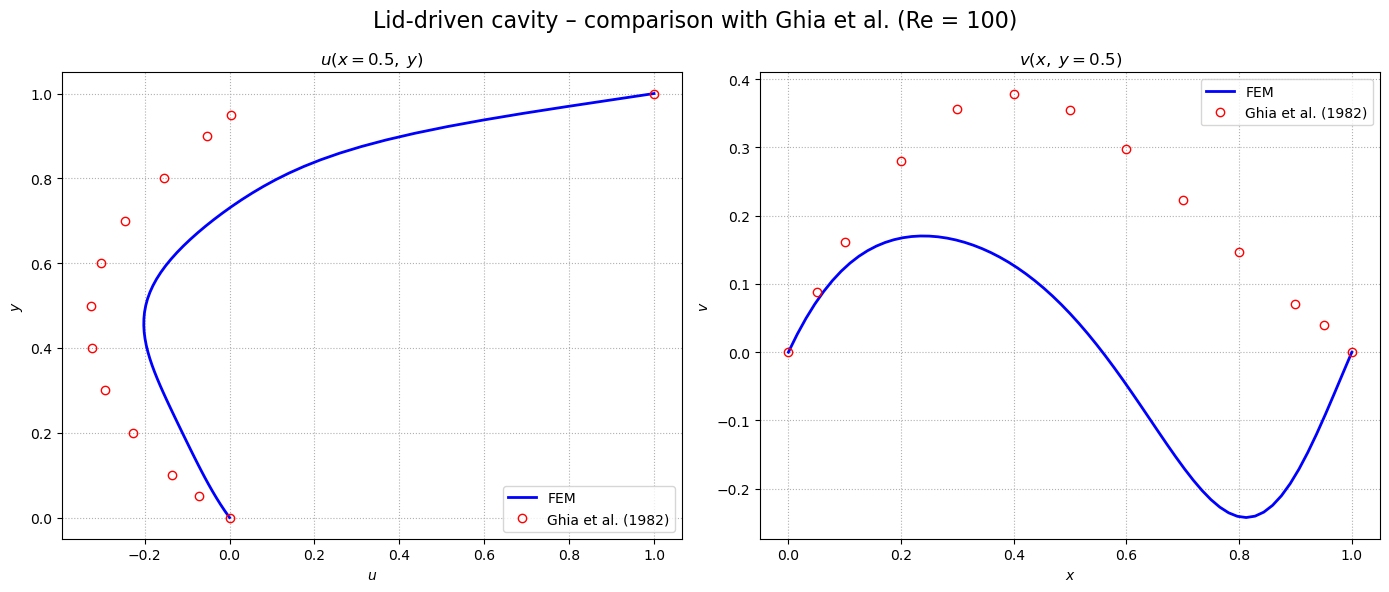

In [21]:
import numpy as np
import matplotlib.pyplot as plt


def _extract_profile_1d(field_name: str,
                        dof_handler,
                        values: np.ndarray,
                        *,
                        line_axis: str,
                        line_pos: float,
                        atol: float = 1e-10):
    """
    Collect <values> of a scalar field along either
        - the vertical   line x = line_pos   (line_axis='x'),  or
        - the horizontal line y = line_pos   (line_axis='y').

    Repeated coordinates (may happen with high-order elements) are
    grouped and averaged so the returned arrays contain unique, sorted
    locations and one value per location.
    """
    # 1. coordinates of *all* DOFs of this field
    coords = dof_handler.get_dof_coords(field_name)        # shape (n_dofs,2)

    if line_axis.lower() == "x":         # vertical centre-line
        mask = np.isclose(coords[:, 0], line_pos, atol=atol)
        line_coord = coords[mask, 1]     # y-coordinates
    elif line_axis.lower() == "y":       # horizontal centre-line
        mask = np.isclose(coords[:, 1], line_pos, atol=atol)
        line_coord = coords[mask, 0]     # x-coordinates
    else:
        raise ValueError("line_axis must be 'x' or 'y'.")

    vals_on_line = values[mask]

    # 2. group (coord,value) pairs that are numerically identical
    #    → one representative per coordinate
    unique_map = {}          # coord -> list of values
    for c, v in zip(line_coord, vals_on_line):
        key = float(f"{c:.12f}")         # round to 1e-12 for stability
        unique_map.setdefault(key, []).append(v)

    sorted_items = sorted(unique_map.items())      # sort by coord
    coords_out = np.array([k for k, _ in sorted_items])
    vals_out   = np.array([np.mean(vs) for _, vs in sorted_items])
    return coords_out, vals_out
# ---------------------------------------------------------------------------


def create_verification_plot(dh, u_vec, reference_data, *,
                             x_center=0.5, y_center=0.5):
    """
    Compare the FEM velocity field *u_vec* (VectorFunction) against the
    Ghia et al. (1982) reference data for Re=100.

    Parameters
    ----------
    dh : DofHandler
        The handler that owns *u_vec*.
    u_vec : VectorFunction
        Solution with components ['ux', 'uy'].
    reference_data : dict
        Dict with keys 'x_locations', 'y_locations',
        'u_velocity_on_vertical_centerline',
        'v_velocity_on_horizontal_centerline'.
    x_center, y_center : float, optional
        Position of the vertical / horizontal centre-lines.
    """
    # ------------------------------------------------------------------
    # 1. Extract smooth centre-line profiles from the solution
    # ------------------------------------------------------------------
    ux_vals = u_vec.components[0].nodal_values   # or u_vec[0].nodal_values
    uy_vals = u_vec.components[1].nodal_values

    y_sol, u_sol = _extract_profile_1d('ux', dh, ux_vals,
                                       line_axis='x', line_pos=x_center)
    x_sol, v_sol = _extract_profile_1d('uy', dh, uy_vals,
                                       line_axis='y', line_pos=y_center)

    # ------------------------------------------------------------------
    # 2. Plot comparison
    # ------------------------------------------------------------------
    fig, (ax_u, ax_v) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    fig.suptitle("Lid-driven cavity – comparison with Ghia et al. (Re = 100)",
                 fontsize=16)

    # u-velocity along vertical centre-line
    ax_u.plot(u_sol, y_sol, 'b-', lw=2, label='FEM')
    ax_u.plot(reference_data['u_velocity_on_vertical_centerline'],
              reference_data['y_locations'],
              'ro',  mfc='none', label='Ghia et al. (1982)')
    ax_u.set_xlabel(r'$u$');  ax_u.set_ylabel(r'$y$')
    ax_u.set_title(r'$u(x=0.5,\;y)$')
    ax_u.grid(ls=':')
    ax_u.legend()

    # v-velocity along horizontal centre-line
    ax_v.plot(x_sol, v_sol, 'b-', lw=2, label='FEM')
    ax_v.plot(reference_data['x_locations'],
              reference_data['v_velocity_on_horizontal_centerline'],
              'ro',  mfc='none', label='Ghia et al. (1982)')
    ax_v.set_xlabel(r'$x$');  ax_v.set_ylabel(r'$v$')
    ax_v.set_title(r'$v(x,\;y=0.5)$')
    ax_v.grid(ls=':')
    ax_v.legend()

    plt.tight_layout()
    plt.show()

create_verification_plot(dof_handler, u_n, ghia_data_re100)